In [1]:
import pandas as bpd
import numpy as np
import matplotlib.pyplot as plt
import requests as req
import json
import urllib

In [2]:
default_headers = { #Make sure that user-agent is clear
    'User-Agent': "COGS9-PackageManager-DataAnalysis"
}

In [3]:
#def make_pypi_index(): # Not needed, contains over 100K packages with no recent downloads
#    uri = "https://pypi.org/simple/" # simple index URI
#    pypi_index_response = req.get(uri, headers=default_headers)
#    return np.array(
#        list(
#            map(
#                (
#                    lambda first_part:
#                    first_part.split("</a")[0]
#                ),
#                pypi_index_response.text.split("\">")[1:]
#            )
#        )
#    )

In [4]:
#len(make_pypi_index())

In [5]:
def make_gem_index(page=0, previous_data=[]): # Recursive function to make gems index
    max_pages = 1000 # Stop after 1000 pages
    uri = "https://rubygems.org/api/v1/search.json?query=downloads%3A+>0&page=" + str(page) # Generate search URI
    gem_index_response = req.get(uri, headers=default_headers) # Get search URI
    if(
        gem_index_response.text != "[]" # Page after last page returns empty array
        and page < max_pages
    ):
        response_object = json.loads(gem_index_response.text) # Read page into JSON
        read_data = np.array(
            list(
                map(
                    lambda package: {
                        "name": package["name"],
                        "uri": package["gem_uri"],
                        "downloads": int(package["downloads"])
                    }
                    , response_object)
            )
        ) # Weird map thing to make it all into one array
        return make_gem_index(page=page + 1, previous_data=np.append(previous_data, read_data)) # Get the next page
    else: # Once searching is done, or on max page
        return previous_data # Break out

In [6]:
gem_index = bpd.DataFrame(list(make_gem_index())).set_index("name") # Make gem index -> DataFrame
gem_index

,uri,downloads
name,,
rspec-expectations,https://rubygems.org/gems/rspec-expectations-3...,559275412
rspec-core,https://rubygems.org/gems/rspec-core-3.10.0.gem,558383608
rspec-mocks,https://rubygems.org/gems/rspec-mocks-3.10.0.gem,553411471
diff-lcs,https://rubygems.org/gems/diff-lcs-1.4.4.gem,553187906
bundler,https://rubygems.org/gems/bundler-2.2.2.gem,533500816
...,...,...
autoscaler,https://rubygems.org/gems/autoscaler-1.0.0.gem,87982
activerecord-after-transaction,https://rubygems.org/gems/activerecord-after-t...,87977
uri-query_params,https://rubygems.org/gems/uri-query_params-0.7...,87974


In [7]:
node_data = bpd.read_csv("data/npm_csv.csv") # Read NPM CSV; if this errors, you might have to manually download the file from the repo

In [8]:
node_data = node_data[
    node_data
    .get("uri")
    .apply(lambda uri:
           type(uri) != float) # If the download URI doesn't exist, it shows up as NaN -> which has type float so remove those.
].set_index("name") 
node_data

,uri
name,
format-text,https://registry.npmjs.org/format-text/-/forma...
new-chain,https://registry.npmjs.org/new-chain/-/new-cha...
uniques,https://registry.npmjs.org/uniques/-/uniques-0...
ansi-codes,https://registry.npmjs.org/ansi-codes/-/ansi-c...
door,https://registry.npmjs.org/door/-/door-0.0.1-s...
...,...
vue3-scroll-picker,https://registry.npmjs.org/vue3-scroll-picker/...
com.fight4dream.locomotors.moveinplace.unity,https://registry.npmjs.org/com.fight4dream.loc...
demo11.12,https://registry.npmjs.org/demo11.12/-/demo11....


In [9]:
def get_node_download_count(package):
    uri = "https://api.npmjs.org/downloads/point/2010-01-01:2030-01-01/" + package # Build API URI
    info_response = req.get(uri, headers=default_headers) # Read API
    if(info_response.status_code != 200 or type(json.loads(info_response.text).get('error', -1)) != int): # Make sure entry exists
        return -1 # Return -1 if in error
    return json.loads(info_response.text)["downloads"]

In [10]:
def get_uri_size(uri): # URI size in bytes
    if(uri == ""):
        return -1
    data = urllib.request.urlopen(uri, timeout=10000) # Not sure if the timeout does anything, put it in just in case
    data.close()
    return int(data.info()["Content-Length"]) # Content of "Content-Length" header

In [11]:
pypi_index = bpd.read_csv("data/pypi_csv.csv").set_index("name") # Read PYPI csv 
pypi_index = pypi_index.assign(downloads=pypi_index.get("num_downloads")).drop(columns=["num_downloads"]) # Rename the num_downloads column to downloads
pypi_index

,downloads
name,
urllib3,2301518
six,1668852
botocore,1646210
requests,1572936
certifi,1521324
...,...
outliers-remover-101883060-1,1
octopussh,1
riskscore,1


In [12]:
def get_pypi_uri(project): # Generate download URI
    uri = "https://pypi.org/pypi/" + str(project) + "/json" # Make API URI
    info_response = req.get(uri, headers=default_headers) # Read API
    if(info_response.status_code != 200): # Make sure entry exists
        return ""
    response_json = json.loads(info_response.text) # Load JSON from response
    return (
        response_json["urls"][0]["url"] # Get first download URI, sometimes it does not exist
            if 
                len(response_json["urls"]) > 0
            else 
                (print("package with no uri"), "")[1] # Return an empty string if no download URI (size goes to -1 in get_uri_size if fed an empty string)
    )

In [13]:
def get_pypi_size(project): # Get download size of PYPI package from name
    return get_uri_size(get_pypi_uri(project))

In [14]:
gem_sizes = gem_index.sample(100).apply(lambda row: (get_uri_size(row.uri)), axis=1) # Make gem sizes of random sample of 100
gem_sizes.name = "size" # Name series so that it can be merged
gem_with_sizes = gem_index.merge(gem_sizes, left_index=True, right_index=True) # Merge gems and file sizes
gem_with_sizes

,uri,downloads,size
name,,,
Ascii85,https://rubygems.org/gems/Ascii85-1.1.0.gem,21891891,12288
GeoRuby,https://rubygems.org/gems/GeoRuby-1.3.4.gem,280190,55808
actionmailbox,https://rubygems.org/gems/actionmailbox-6.1.0.gem,19248264,22016
active-triples,https://rubygems.org/gems/active-triples-1.1.1...,260942,67072
active_admin-sortable_tree,https://rubygems.org/gems/active_admin-sortabl...,162655,17920
...,...,...,...
toml,https://rubygems.org/gems/toml-0.2.0.gem,10033058,10240
vagrant-vbguest,https://rubygems.org/gems/vagrant-vbguest-0.28...,1722911,40448
vault-tools,https://rubygems.org/gems/vault-tools-2.0.2.gem,92621,27136


In [15]:
node_sample = node_data.sample(100)
node_downloads = node_sample.apply(lambda row: (get_node_download_count(row.name)), axis=1) # Take downloads
node_downloads.name = "downloads"
node_sizes = node_sample.apply(lambda row: get_uri_size(row.uri), axis=1) # See above ^
node_sizes.name = "size"
node_with_sizes = node_data.merge(node_sizes, left_index=True, right_index=True).merge(node_downloads, left_index=True, right_index=True)
node_with_sizes[node_with_sizes.get("downloads") != -1]

,uri,size,downloads
name,,,
@blokz/cli,https://registry.npmjs.org/@blokz/cli/-/cli-0....,17134,977
@chaosxu/cli,https://registry.npmjs.org/@chaosxu/cli/-/cli-...,6545,690
@darius-kiuberis/object-helpers,https://registry.npmjs.org/@darius-kiuberis/ob...,461,133
@evan.network/dbcp,https://registry.npmjs.org/@evan.network/dbcp/...,7264787,9727
@extra-regexp/escape,https://registry.npmjs.org/@extra-regexp/escap...,1541,452
...,...,...,...
vue-cropper-simple,https://registry.npmjs.org/vue-cropper-simple/...,228026,502
vuejs-light-tag-component,https://registry.npmjs.org/vuejs-light-tag-com...,1479,87
weather,https://registry.npmjs.org/weather/-/weather-1...,14203,21431


In [16]:
pypi_sizes = pypi_index.sample(100).apply(lambda row: get_pypi_size(row.name), axis=1) # See above ^
pypi_sizes.name = "size"
pypi_with_sizes = pypi_index.merge(pypi_sizes, left_index=True, right_index=True)
pypi_with_sizes = pypi_with_sizes[pypi_with_sizes.get("size") != -1]
pypi_with_sizes

package with no uri


,downloads,size
name,,
stringcase,12649,2958
django-ipware,6926,9022
slimit,676,88217
mode,487,100623
objax,189,41248
...,...,...
docker-tutorial,1,158921
funcserver,1,247878
awesomestream,1,8445


In [407]:
for datum in [("pypi_sizes.csv",pypi_with_sizes.to_csv()),("node_sizes.csv",node_with_sizes.to_csv()),("gem_sizes.csv",gem_with_sizes.to_csv())]:
    f = open("data/" + datum[0], "w")
    f.write(datum[1])
    f.close()

In [408]:
pypi_with_sizes = bpd.read_csv("data/pypi_sizes.csv")
node_with_sizes = bpd.read_csv("data/node_sizes.csv")
gem_with_sizes = bpd.read_csv("data/gem_sizes.csv")

In [413]:
def plot_data(data, title="",scale_downloads=1,scale_size=1,x_label="",y_label=""):
    interquartile_range = lambda column: np.percentile(column, 75) - np.percentile(column, 25)
    inner_fence = lambda column: (np.percentile(column, 25) - 1.5 * interquartile_range(column),
                                  np.percentile(column, 75) + 1.5 * interquartile_range(column))
    outer_fence = lambda column: (np.percentile(column, 25) - 3 * interquartile_range(column),
                                  np.percentile(column, 75) + 3 * interquartile_range(column))
    column_outlier = (lambda datum, column:
                    0 if (datum >= inner_fence(column)[0] and datum <= inner_fence(column)[1]) 
                    else (
                        1 if (datum >= outer_fence(column)[0] and datum <= outer_fence(column)[1])
                         else 2
                    )
                   )
    is_outlier = (lambda row, all_size, all_downloads:
                  (column_outlier(row["size"], all_size), column_outlier(row.downloads, all_downloads))
                 )
    data_standard = (
        (data - data.mean()) / data.std()
    )
    data_scaled = (
        data
        .assign(
            size=(
                data.get("size") / scale_size
            ),downloads=(
                data.get("downloads") / scale_downloads
            ),
            outlier_size=(
                data.apply(
                    lambda row: is_outlier(row, data.get("size"), data.get("downloads"))[0],
                    axis=1
                )
            ),
            outlier_downloads=(
                data.apply(
                    lambda row: is_outlier(row, data.get("size"), data.get("downloads"))[1],
                    axis=1
                )
            )
        )
    )
    data_scaled[(data_scaled.get("outlier_size") == 0) & (data_scaled.get("outlier_downloads") == 0)].plot(
        kind="scatter",
        x="downloads",
        y="size",
        label="Packages",
        figsize=(10,5)
    )
    for dataset in ([
            (data_scaled[data_scaled.get("outlier_size") == 1], "Minor Size Outliers"),
            (data_scaled[data_scaled.get("outlier_size") == 2],"Major Size Outliers"),
            (data_scaled[data_scaled.get("outlier_downloads") == 1],"Minor Downloads Outliers"),
            (data_scaled[data_scaled.get("outlier_downloads") == 2],"Major Downloads Outliers")
        ]):
        plt.scatter(
            x=dataset[0].get("downloads"),
            y=dataset[0].get("size"),
            #color=dataset[1],
            alpha=0.5,
            label=dataset[1])
   
    plt.xlabel(
        x_label#,
        #fontsize="xx-large"
    )
    plt.ylabel(
        y_label#,
        #fontsize="xx-large"
    )
    plt.title(
        title#,
        #fontsize="xx-large"
    )
    r = data_standard.apply(
        lambda row: row.downloads * row.size
        , axis=1
    ).mean()
    slope = (
        r / 
        data_scaled.get("downloads").std() * 
        data_scaled.get("size").std()
    )
    intercept = (
        slope * -1 * data_scaled.get("downloads").mean()
        + data_scaled.get("size").mean()
    )
    generate_y = lambda x: intercept + slope * x

    x0,x1 = plt.xlim()
    y0,y1 = plt.ylim()
    
    plt.plot(
        (0,
         generate_y(0)
        ),
        (data_scaled.get("downloads").max(),
         generate_y(data_scaled.get("downloads").max())
        ),
        label="Line of Best Fit",
        alpha=0.3,
        color="k"
    )
    
    plt.xlim(x0,x1)
    plt.ylim(y0,y1)
    plt.legend(bbox_to_anchor=(1.5,0.8))
    plt.show()
    return r

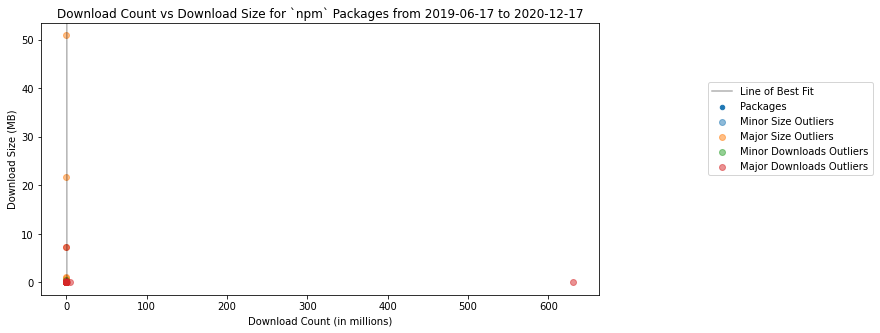

7.694615022154551e-18

In [414]:
plot_data(node_with_sizes,
          title="Download Count vs Download Size for `npm` Packages from 2019-06-17 to 2020-12-17",
          scale_downloads=1e6,
          scale_size=1e6,
          x_label="Download Count (in millions)",
          y_label="Download Size (MB)")

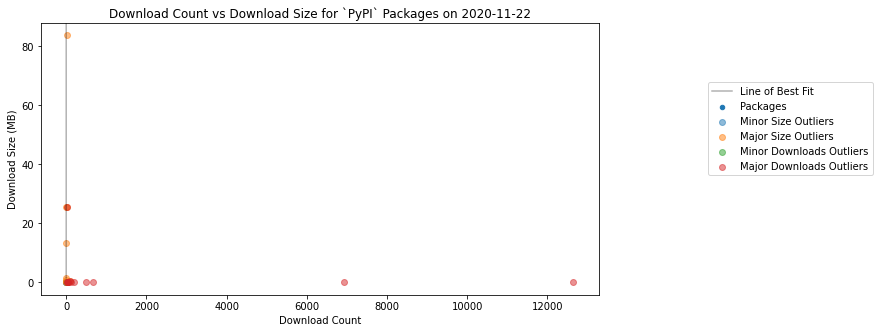

2.6914497566670462e-17

In [415]:
plot_data(pypi_with_sizes,
          title="Download Count vs Download Size for `PyPI` Packages on 2020-11-22",
          scale_downloads=1,
          scale_size=1e6,
          x_label="Download Count",
          y_label="Download Size (MB)")

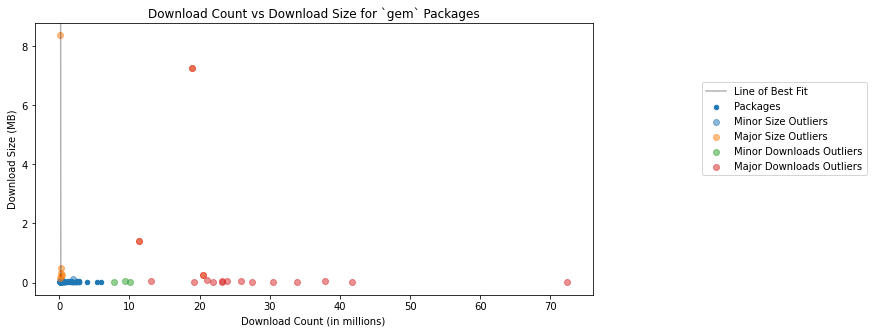

-3.9968028886505634e-17

In [416]:
plot_data(gem_with_sizes,
          title="Download Count vs Download Size for `gem` Packages",
          scale_downloads=1e6,
          scale_size=1e6,
          x_label="Download Count (in millions)",
          y_label="Download Size (MB)")

In [301]:
("pypi",pypi_with_sizes.describe(),"node",node_with_sizes.describe(),"gem", gem_with_sizes.describe())

('pypi',
           downloads          size
 count     99.000000  9.900000e+01
 mean     219.424242  1.551060e+06
 std     1442.674940  9.157590e+06
 min        1.000000  4.920000e+02
 25%        1.000000  3.932000e+03
 50%        2.000000  9.834000e+03
 75%        7.000000  4.559400e+04
 max    12649.000000  8.353992e+07,
 'node',
                size     downloads
 count  1.010000e+02  1.010000e+02
 mean   8.459982e+05  6.307285e+06
 std    5.518517e+06  6.278876e+07
 min    2.500000e+02  7.600000e+01
 25%    1.822000e+03  1.730000e+02
 50%    5.234000e+03  3.640000e+02
 75%    1.793000e+04  1.183000e+03
 max    5.087869e+07  6.310631e+08,
 'gem',
           downloads          size
 count  1.000000e+02  1.000000e+02
 mean   5.596490e+06  2.134682e+05
 std    1.155638e+07  1.104724e+06
 min    8.824700e+04  4.096000e+03
 25%    1.788738e+05  1.228800e+04
 50%    4.689175e+05  2.380800e+04
 75%    2.744576e+06  4.876800e+04
 max    7.238892e+07  8.363008e+06)